In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os

from common import h5dataset, trainer, onnxexporter, model_dnn

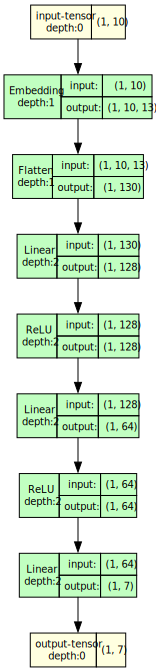

In [8]:
# Plot model graph

model = model_dnn.ModelDNN(
    name="JassTrump",
    input_size=10,
    embedding_size=13,
    hidden_size=[128, 64],
    output_size=7,
)

model_graph = draw_graph(model, torch.zeros(1, 10).long(), show_shapes=True)
model_graph.visual_graph

In [9]:
DATASET_PATH = '../log_parser/dataset/flat_trump.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/trump'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/trump'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [10]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Initialize model, optimizer, and loss function
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()
loss_fn = lambda y_pred, y_true: F.nll_loss(F.log_softmax(y_pred, dim=1), y_true)

# set up trainer
trainer = trainer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [11]:
# train the model
trainer.train(NUM_EPOCHS, model, optimizer)

Training model: JassTrump_128_64_dnn


Validation Epoch 1: 100%|██████████| 1650/1650 [00:05<00:00, 321.77it/s]


Epoch 1/20 - Train Loss: 0.5913, Train Accuracy: 77.1520, Val Loss: 0.5456, Val Accuracy: 78.8972
Model saved at epoch 1 with validation loss 0.5456


Validation Epoch 2: 100%|██████████| 1650/1650 [00:04<00:00, 343.49it/s]


Epoch 2/20 - Train Loss: 0.5329, Train Accuracy: 79.2551, Val Loss: 0.5324, Val Accuracy: 79.3046
Model saved at epoch 2 with validation loss 0.5324


Validation Epoch 3: 100%|██████████| 1650/1650 [00:04<00:00, 344.40it/s]


Epoch 3/20 - Train Loss: 0.5231, Train Accuracy: 79.6196, Val Loss: 0.5269, Val Accuracy: 79.4467
Model saved at epoch 3 with validation loss 0.5269


Validation Epoch 4: 100%|██████████| 1650/1650 [00:05<00:00, 305.10it/s]


Epoch 4/20 - Train Loss: 0.5177, Train Accuracy: 79.7998, Val Loss: 0.5286, Val Accuracy: 79.3345


Validation Epoch 5: 100%|██████████| 1650/1650 [00:05<00:00, 329.92it/s]


Epoch 5/20 - Train Loss: 0.5135, Train Accuracy: 79.9388, Val Loss: 0.5204, Val Accuracy: 79.7691
Model saved at epoch 5 with validation loss 0.5204


Validation Epoch 6: 100%|██████████| 1650/1650 [00:04<00:00, 354.02it/s]


Epoch 6/20 - Train Loss: 0.5101, Train Accuracy: 80.0206, Val Loss: 0.5206, Val Accuracy: 79.7515


Validation Epoch 7: 100%|██████████| 1650/1650 [00:05<00:00, 319.62it/s]


Epoch 7/20 - Train Loss: 0.5073, Train Accuracy: 80.1061, Val Loss: 0.5199, Val Accuracy: 79.6765
Model saved at epoch 7 with validation loss 0.5199


Validation Epoch 8: 100%|██████████| 1650/1650 [00:05<00:00, 317.77it/s]


Epoch 8/20 - Train Loss: 0.5055, Train Accuracy: 80.1949, Val Loss: 0.5174, Val Accuracy: 79.8613
Model saved at epoch 8 with validation loss 0.5174


Validation Epoch 9: 100%|██████████| 1650/1650 [00:04<00:00, 330.27it/s]


Epoch 9/20 - Train Loss: 0.5038, Train Accuracy: 80.2723, Val Loss: 0.5152, Val Accuracy: 79.9442
Model saved at epoch 9 with validation loss 0.5152


Validation Epoch 10: 100%|██████████| 1650/1650 [00:04<00:00, 336.56it/s]


Epoch 10/20 - Train Loss: 0.5026, Train Accuracy: 80.3035, Val Loss: 0.5170, Val Accuracy: 79.9196


Validation Epoch 11: 100%|██████████| 1650/1650 [00:05<00:00, 315.28it/s]


Epoch 11/20 - Train Loss: 0.5013, Train Accuracy: 80.3319, Val Loss: 0.5170, Val Accuracy: 79.9249


Validation Epoch 12: 100%|██████████| 1650/1650 [00:04<00:00, 359.07it/s]

Epoch 12/20 - Train Loss: 0.5005, Train Accuracy: 80.3889, Val Loss: 0.5177, Val Accuracy: 79.8596


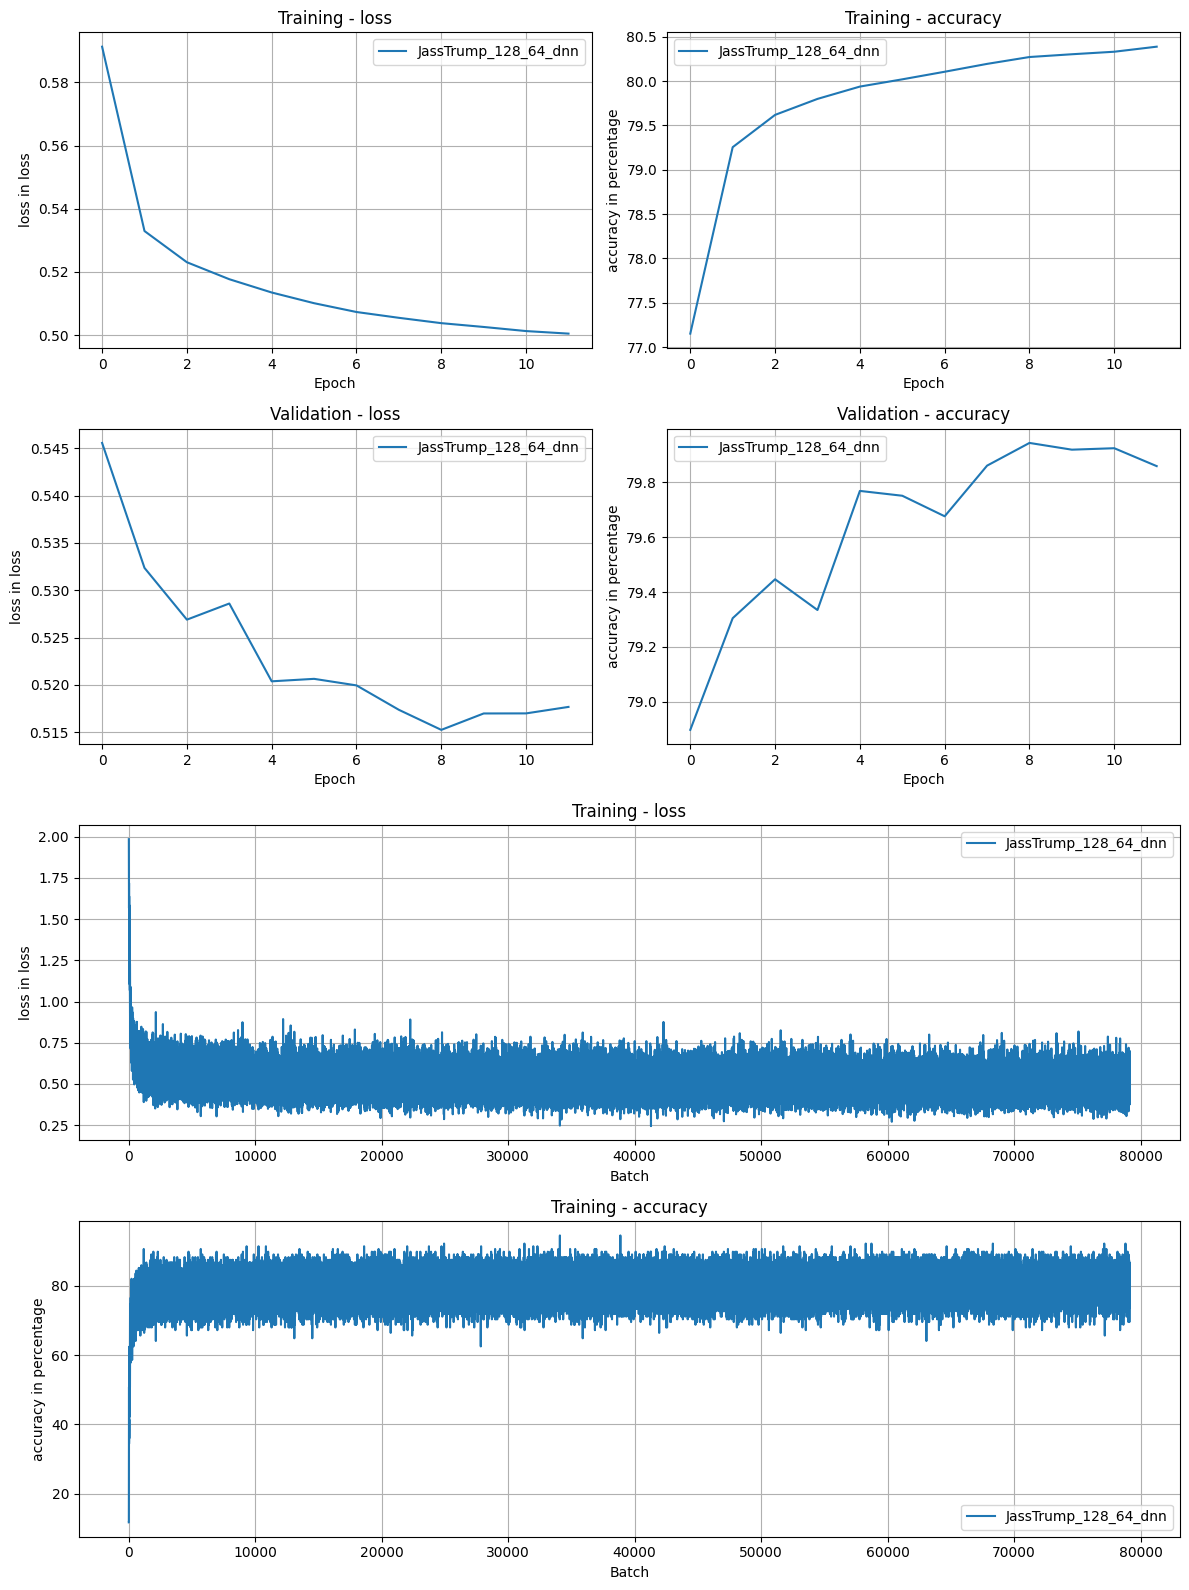

In [12]:
# create graphs
trainer.monitor.plot()

In [13]:
trainer.monitor.dump(LOGS_PATH)

In [14]:
# export the model to ONNX
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model = model.to('cpu')
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    in_dim=10,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/trump/JassTrump_128_64_dnn.onnx
